# Imports

In [1]:
import numpy as onp
import matplotlib.pyplot as plt

In [2]:
%%capture
!pip install jax-md
!pip install optax
!pip install equinox
import jax.numpy as np

In [3]:
%cd ..

/net/fs-brenner01/srv/export/brenner_lab/share/Lab/morphogenesis/jax-morph


In [4]:
from jax import random, vmap
from jax_md import space, quantity 
from jax_morph import datastructures, visualization, cell_division, cell_growth, simulation
from Francesco.chem_twotypes import initial_states, secdiff
from Francesco.chem_twotypes import divrates as divrates_chem
from Ramya.mech_homogeneous_growth import chemical, mechanical, divrates, optimize
from functools import partial
import equinox as eqx

RuntimeError: jaxlib/cuda/cusolver_kernels.cc:45: operation cusolverDnCreate(&handle) failed: cuSolver internal error

In [ ]:
# The warnings annoy me :(
import warnings
warnings.filterwarnings('ignore')

In [ ]:
%load_ext autoreload
%autoreload 2

# Params

In [ ]:
def _maybe_array(name, value, train_params):
    if train_params[name]:
        return np.array(value)
    else:
        return value

In [ ]:
# @title Define Params
# Define parameters --blue particles are type 1, orange are type 2
# keep type casting to place vars in gpu memory

# Number of chemical signals
n_chem = 2


### CELL DIMENSIONS
cellRad = .5
cellRadBirth = float(cellRad / np.sqrt(2))


### DIFFUSION

# No diffusion or secretion in my simulation - only external chemical field over positions
diffCoeff = np.ones(n_chem) 
degRate = np.ones(n_chem) 

# diffusion cutoff
r_cutoffDiff = 5.*cellRad
r_onsetDiff = r_cutoffDiff - .5

# CHEMICAL FIELD
chem_max = 100.0
chem_k = 2.0
chem_gamma = 0.4

### SECRETION

# sec rate that gives concentration 1 at source at SS
sec_max_unitary = 2*np.sqrt(diffCoeff*degRate)

sec_max = sec_max_unitary*np.ones((n_chem,), dtype=np.float32)
#sec_max = sec_max.at[0].set(10)

sec_gamma = np.ones((n_chem,n_chem), dtype=np.float32) #was 0.01
sec_k = np.ones((n_chem,n_chem), dtype=np.float32) 
#secreted_by_ctypes = np.ones((n_chem, 1))
ctype_sec_chem = np.eye(2, 2)

# GROWTH

div_gamma = np.append(
    np.array([0.001, -0.001]),
    0.5*np.ones(n_chem)
)
div_k = np.append(
    np.array([-20.0, 20.0]),
    -6.0*np.ones(n_chem)
)


# MORSE POTENTIAL
# always use python scalars
alpha = 3.
eps_TwoTwo = 2. #orange
eps_OneOne = 2. #blue
eps_OneTwo = 2. 

# morse cutoff
r_cutoff = 4.*cellRad
r_onset = r_cutoff - .2


# number of gradient descent steps for Morse potential minimization
mech_relaxation_steps = 10


# Initialization and number of added cells. 
ncells_init = 10 #number of cells in the initial cluster
n_ones_init = 5 #number of type-1 cell in the initail cluster
ncells_add = 100

In [ ]:
#@title Define trainable params
train_params = {
    'n_chem': False,
    
    'sec_max': False,
    'sec_gamma': False,
    'sec_k' : False,
    'ctype_sec_chem': False,
    
    'div_gamma' : False,
    'div_k' : False,
    
    'cellRad' : False,
    'cellRadBirth' : False,
    
    'diffCoeff' : True,
    'degRate' : False,
    'r_onsetDiff' : False,
    'r_cutoffDiff' : False,
    
    'alpha': False, 
    'eps_TwoTwo': False, 
    'eps_OneOne' : False,
    'eps_OneTwo' : False,
    'r_onset' : False,
    'r_cutoff' : False,
    'mech_relaxation_steps' : False,
    
    'ncells_init' : False,
    'n_ones_init': False, 
    'ncells_add': False,

    'chem_max': False, 
    'chem_k': False,
    'chem_gamma': False
}

In [ ]:
#@title Initialize params
params = {
    'n_chem': n_chem,
    
    'sec_max': sec_max,
    'sec_gamma': sec_gamma,
    'sec_k' : sec_k,
    'ctype_sec_chem' : ctype_sec_chem,
    'div_gamma' : div_gamma,
    'div_k' : div_k,
    
    'cellRad' : cellRad,
    'cellRadBirth' : cellRadBirth,
    
    'diffCoeff' : diffCoeff,
    'degRate' : degRate,
    'r_onsetDiff' : r_onsetDiff,
    'r_cutoffDiff' : r_cutoffDiff,
    
    'alpha': _maybe_array('alpha', alpha, train_params), 
    'eps_TwoTwo': _maybe_array('eps_TwoTwo', eps_TwoTwo, train_params), 
    'eps_OneOne' : _maybe_array('eps_OneOne', eps_OneOne, train_params),
    'eps_OneTwo' : _maybe_array('eps_OneTwo', eps_OneTwo, train_params),
    'r_onset' : r_onset,
    'r_cutoff' : r_cutoff,
    'mech_relaxation_steps' : mech_relaxation_steps,
    
    'ncells_init' : ncells_init,
    'n_ones_init': n_ones_init, 
    'ncells_add': ncells_add,

    'chem_max': chem_max,
    'chem_k': chem_k,
    'chem_gamma': chem_gamma
}

# Set up simulation

In [ ]:
key = random.PRNGKey(15)
fspace = datastructures.SpaceFunc(*space.free())
istate = initial_states.init_state_grow(key, params, fspace)

In [ ]:
# init division nn
DIV_HIDDEN = [10]*2
div_init, div_nn_apply = divrates_chem.div_nn(params,train_params,DIV_HIDDEN,train=True)
params, train_params = div_init(istate, key)

In [ ]:
#init secretion nn
SEC_HIDDEN = [10]*2
use_state_fields=datastructures.CellState(*tuple([False]*3+[True]+[False]*4))
sec_init, sec_nn_apply = secdiff.sec_nn(params,train_params,SEC_HIDDEN, train=True, use_state_fields=use_state_fields)
params, train_params = sec_init(istate, key)

In [ ]:
fstep = [
    cell_division.S_cell_division,
    cell_growth.S_grow_cells,
    mechanical.S_mechmin_twotypes,
    partial(secdiff.S_ss_chemfield, sec_fn=sec_nn_apply),
    #chemical.S_fixed_chemfield,
    divrates.S_set_stress,
    partial(divrates_chem.S_set_divrate, divrate_fn=eqx.filter_jit(div_nn_apply))
]
sim_init, sim_step = simulation.simulation(fstep, params, fspace)

In [149]:
%%time
# run entire simulation
fstate, state_all = simulation.sim_trajectory(istate, sim_init, sim_step, key=key, history=True)

CPU times: user 1.8 s, sys: 94.5 ms, total: 1.89 s
Wall time: 1.9 s


<AxesSubplot:>

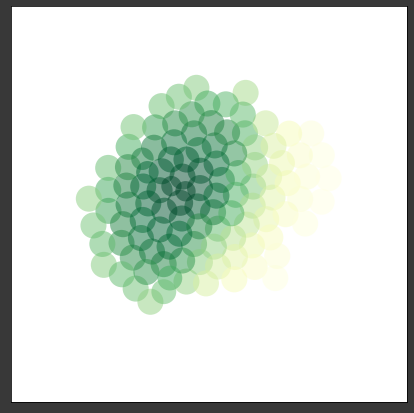

In [150]:
visualization.draw_circles_chem(fstate)

# Optimization

In [151]:
import optax
from jax import value_and_grad, lax
from Ramya.mech_homogeneous_growth.optimize import avg_loss

## Tunnel loss

In [152]:
def tunnel_metric(state):
    '''
    Costrain cell growth in a vertical "tunnel".
    '''    
    p = np.sum(np.where(np.abs(state.position[:,0])<2.,-1.,2)*np.where(state.celltype>0,1,0))    
    r=0.
    m = (p+r)/np.where(state.celltype>0,1,0).sum() 
    return m

In [222]:
def elongation_metric(state):
    '''
    Evaluate asymmetry of cell growth.
    '''
    eig, A = np.linalg.eigh(np.cov(state.position.T))
    pos_aligned = state.position @ A    
    p = np.sum(np.where(np.abs(pos_aligned[:,0])<2.,-1.,2)*np.where(state.celltype>0,1,0))    
    #r = np.sum(np.where((np.abs(state.position[:,0])<2.) * (np.abs(state.position[:,1])>3.),-4,0)*np.where(state.celltype>0,1,0))   
    r=0.    
    m = (p+r)/np.where(state.celltype>0,1,0).sum()
    # m = state.chemical[:,0]*np.where(state.celltype>0,1,0)
    # m = m.mean()   
    return m

In [220]:
@eqx.filter_jit
@eqx.filter_vmap(default=None, kwargs=dict(sim_key=0))
def shape_loss_fr(params, 
            hyper_params,
            fstep,
            fspace,
            istate,
            sim_key=None,
            metric_fn=None,
            target_metric=0.,
            REINFORCE=True,
            GAMMA=.95,
            TEST=False,
           ):
    '''
    REINFORCE loss with discounting.  
    '''
    
    def _sim_trajectory(istate, sim_init, sim_step, ncells_add, key=None):

        state = sim_init(istate, ncells_add, key)

        def scan_fn(state, i):
            state, logp = sim_step(state)
            loss = np.sum((metric_fn(state) - target_metric)**2)
            loss = np.sqrt(loss)
            return state, (logp, loss)


        iterations = len(state.celltype)-len(istate.celltype)
        iterations = np.arange(iterations)
        fstate, aux = lax.scan(scan_fn, state, iterations)

        return fstate, aux

    # merge params dicts
    all_params = eqx.combine(params, hyper_params)
    
    #simulation length
    ncells_add = all_params['ncells_add']


    #forward pass - simulation
    sim_init, sim_step = simulation.simulation(fstep, all_params, fspace)
    fstate, (logp, losses) = _sim_trajectory(istate, sim_init, sim_step, ncells_add, sim_key)


    
    if REINFORCE:
        
        def _returns_rec(losses):
            Gs=[]
            G=0
            i=0
            for l in losses[::-1]:
                G = l+G*GAMMA
                Gs.append(G)
                i += 1

            return np.array(Gs)[::-1]
        
        iloss = np.sqrt(np.sum((metric_fn(istate) - target_metric)**2))
        rewards = -np.diff(np.append(np.array([iloss]),losses))
        
        #discount rewards
        returns = _returns_rec(rewards)
        
        loss = -np.sum(logp*lax.stop_gradient(returns))#+rewards.sum()
        
        return loss
    
    if TEST:
        return losses, rewards, logp

    else:
        return losses[-1]

In [223]:
EPOCHS = 50
EPISODES_PER_UPDATE = 64 #128
EPISODES_PER_EVAL = 100 #128

LEARNING_RATE = 5e-2

METRIC_FN = elongation_metric
TARGET_METRIC = -1.


rloss = partial(shape_loss_fr, metric_fn=METRIC_FN, target_metric=TARGET_METRIC, REINFORCE=True)
sloss = partial(shape_loss_fr, metric_fn=METRIC_FN, target_metric=TARGET_METRIC, REINFORCE=False)



p, hp = eqx.partition(params, train_params)

# init optimizer
optimizer = optax.adam(LEARNING_RATE)
opt_state = optimizer.init(p)


#--------------------------------------------
#store loss at initial params and calc grad 

key, *batch_subkeys = random.split(key, EPISODES_PER_UPDATE+1)
batch_subkeys = np.array(batch_subkeys)

ll, grads = value_and_grad(avg_loss)(p, hp, rloss, batch_subkeys, fstep=fstep, fspace=fspace, istate=istate)


key, *eval_subkeys = random.split(key, EPISODES_PER_EVAL+1)
eval_subkeys = np.array(eval_subkeys)

l = avg_loss(p, hp, sloss, eval_subkeys, fstep=fstep, fspace=fspace, istate=istate)

#store initial params and loss
loss_t = [float(l)]
params_t = [p]
#rloss_t = [float(ll)]

#print(grads['div_fn']['mlp/~/linear_0']['b'])

#grads_t = [grads]

#--------------------------------------------


for t in range(EPOCHS):
    
    #generate batch of random keys
    key, *batch_subkeys = random.split(key, EPISODES_PER_UPDATE+1)
    batch_subkeys = np.array(batch_subkeys)
        
    #normalize grads
    #grads = jax.tree_map(lambda x: x/np.sqrt(np.sum(x**2)), grads)
    #grads = jax.tree_map(lambda x: -x, grads)
    
    # sgd step
    updates, opt_state = optimizer.update(grads, opt_state, p)

    p = eqx.apply_updates(p, updates)
    
    if None != p['diffCoeff']:
        p['diffCoeff'] = np.where(p['diffCoeff']>.2,p['diffCoeff'],.2)
    
    #estimate actual avg loss
    key, *eval_subkeys = random.split(key, EPISODES_PER_EVAL+1)
    eval_subkeys = np.array(eval_subkeys)

    l = avg_loss(p, hp, sloss, eval_subkeys, fstep=fstep, fspace=fspace, istate=istate)
    #print('Loss:\t', float(l))
    
    # surrogate loss and grads
    ll, grads = value_and_grad(avg_loss)(p, hp, rloss, batch_subkeys, fstep=fstep, fspace=fspace, istate=istate)

    #print(grads['div_fn']['mlp/~/linear_0']['b'])

    #store
    loss_t += [float(l)]
    #rloss_t.append(float(ll))
    params_t += [p]
    #grads_t += [grads]
    
    print(float(l))
    

1.0767271518707275
1.0562726259231567
1.0677272081375122
1.055727243423462
1.0412726402282715
1.0456362962722778
1.0401817560195923
1.045090913772583
1.041272759437561
1.0333635807037354
1.0292725563049316
1.0238181352615356
1.031181812286377
1.0208181142807007
1.025999903678894
1.0191818475723267
1.0292726755142212
1.010454535484314
1.0208181142807007
1.0101817846298218
1.0145454406738281
1.0099090337753296
1.0088181495666504
1.0069090127944946
1.0080000162124634
1.0178180932998657
0.9968181252479553
1.0069090127944946
1.0028181076049805
0.9981817603111267
1.0060908794403076
1.0017272233963013
0.9932726621627808
0.9943636655807495
0.9946363568305969
0.9886363744735718
0.9962727427482605
0.9908181428909302
0.9930000305175781
0.993545413017273
0.9818181991577148
0.9826363325119019
0.9845454692840576
0.9812726974487305
0.9788181781768799
0.9872726798057556
0.9878181219100952
0.9932726621627808
0.9801818132400513
0.9818181991577148


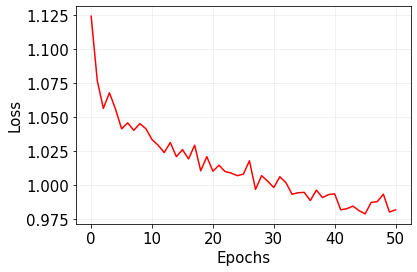

In [224]:
plt.plot(np.array(loss_t), 'r')
#plt.yscale('log')

plt.grid(alpha=.2)


plt.xlabel('Epochs')
plt.ylabel('Loss');

In [225]:
opt_params = eqx.combine(params_t[-1], params)
sim_init, sim_step = simulation.simulation(fstep, opt_params, fspace)
fstate_opt, state_all_opt = simulation.sim_trajectory(istate, sim_init, sim_step, key=key, history=True, ncells_add=200)

In [226]:
def make_cell_state(t, state_all):
    arr = state_all[0]
    state = datastructures.CellState(arr.position[t],
                                arr.celltype[t],
                                arr.radius[t],
                                arr.chemical[t],
                                arr.field[t],
                                arr.divrate[t], 
                                arr.stress[t],
                                arr.key)
    return state
ts = [0, 50, 100, 125, 150, 199]

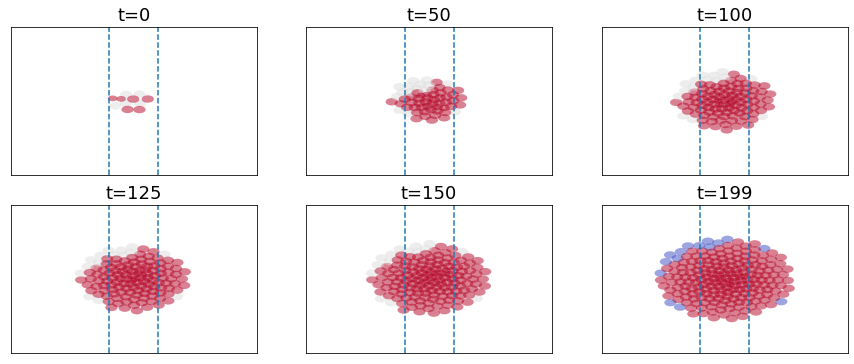

In [227]:
fig, ax = plt.subplots(2, 3, figsize=(15, 6))
for i in range(6):
    state = make_cell_state(ts[i], state_all_opt)
    visualization.draw_circles(state, state.celltype, ax=ax[int(i/3)][i%3],
                              min_coord=-10, max_coord=10)
    #ax[int(i/3)][i%3].vlines(-2, -10, 10, linestyle='dashed')
    #ax[int(i/3)][i%3].vlines(2, -10, 10, linestyle='dashed')
    ax[int(i/3)][i%3].set_title("t=%s" % ts[i])

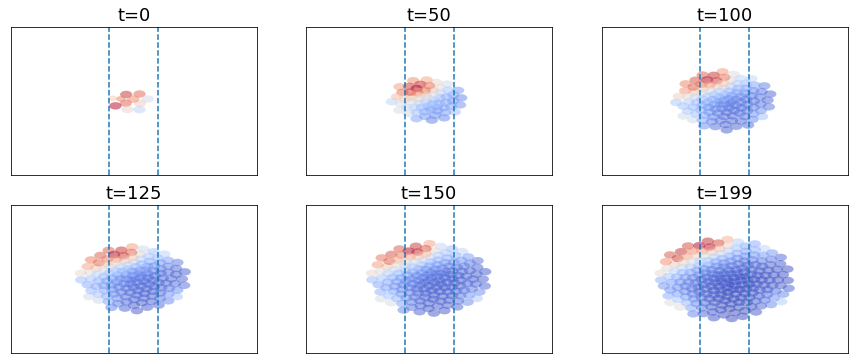

In [228]:
fig, ax = plt.subplots(2, 3, figsize=(15, 6))
for i in range(6):
    state = make_cell_state(ts[i], state_all_opt)
    visualization.draw_circles(state, state.chemical[:, 0], ax=ax[int(i/3)][i%3],
                              min_coord=-10, max_coord=10)
    ax[int(i/3)][i%3].vlines(-2, -10, 10, linestyle='dashed')
    ax[int(i/3)][i%3].vlines(2, -10, 10, linestyle='dashed')
    ax[int(i/3)][i%3].set_title("t=%s" % ts[i])

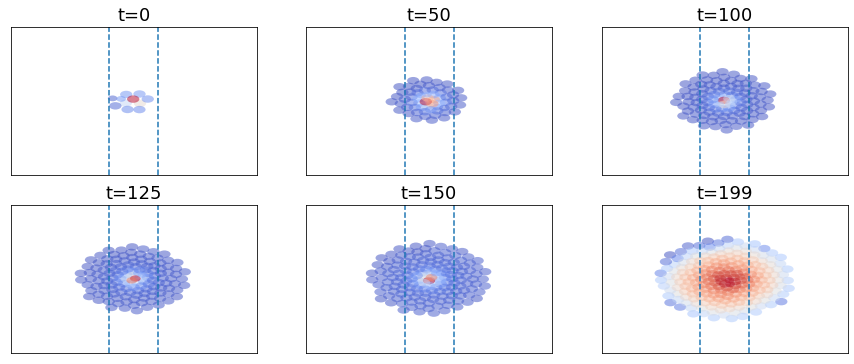

In [229]:
fig, ax = plt.subplots(2, 3, figsize=(15, 6))
for i in range(6):
    state = make_cell_state(ts[i], state_all_opt)
    visualization.draw_circles(state, state.chemical[:, 1], ax=ax[int(i/3)][i%3],
                              min_coord=-10, max_coord=10)
    ax[int(i/3)][i%3].vlines(-2, -10, 10, linestyle='dashed')
    ax[int(i/3)][i%3].vlines(2, -10, 10, linestyle='dashed')
    ax[int(i/3)][i%3].set_title("t=%s" % ts[i])

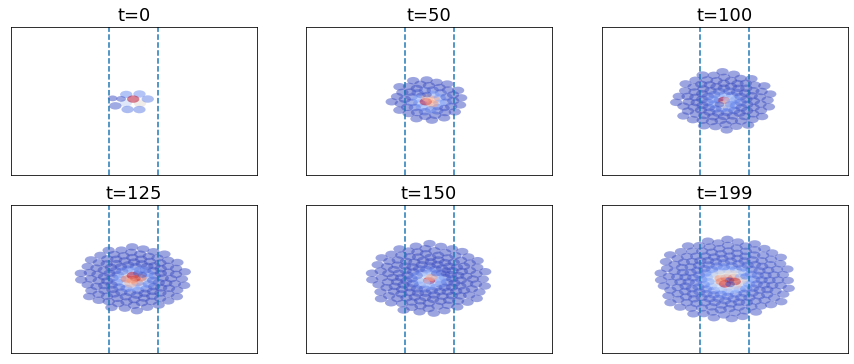

In [230]:
fig, ax = plt.subplots(2, 3, figsize=(15, 6))
for i in range(6):
    state = make_cell_state(ts[i], state_all_opt)
    visualization.draw_circles(state, state.divrate, ax=ax[int(i/3)][i%3],
                              min_coord=-10, max_coord=10)
    ax[int(i/3)][i%3].vlines(-2, -10, 10, linestyle='dashed')
    ax[int(i/3)][i%3].vlines(2, -10, 10, linestyle='dashed')
    ax[int(i/3)][i%3].set_title("t=%s" % ts[i])

# Test solution

In [231]:
opt_params["div_fn"]

{'mlp/~/linear_0': {'b': DeviceArray([-0.8601322 ,  1.3314371 , -0.36031345, -0.8725384 ,
               -1.1437364 , -0.93433595,  0.50972205,  1.2559698 ,
               -0.6732117 ,  0.7719588 ], dtype=float32),
  'w': DeviceArray([[-0.6899526 , -0.54121053,  0.05279855, -0.13131236,
                 0.31621358, -0.37349138,  0.70146084,  0.434347  ,
                -0.10496565, -0.9287607 ],
               [ 0.10355161, -0.9989276 ,  0.2205338 ,  0.612452  ,
                 0.40485853,  0.56119496, -0.9087174 ,  0.16543867,
                 0.2942183 , -1.1192989 ],
               [ 0.74382186,  0.44214925,  0.01349415, -1.0857176 ,
                -0.9205766 ,  0.16434807,  0.3829222 , -0.23718226,
                -0.31045178,  0.3875771 ]], dtype=float32)},
 'mlp/~/linear_1': {'b': DeviceArray([-0.9096487 , -0.6388767 , -0.6997337 , -0.7350196 ,
               -0.38332224, -0.16227525, -0.896546  , -0.8663119 ,
               -0.58675426, -1.2525368 ], dtype=float32),
  'w': Dev

In [232]:
# init division nn
DIV_HIDDEN = [1]
div_init, div_nn_apply = divrates_chem.div_nn(params,train_params,DIV_HIDDEN,train=True)
params, train_params = div_init(istate, key)